# 4. Jacobian IK and Control

In this notebook, we'll demonstrate an extremely simple approach for computing basic inverse kinematics (IK) and controlling the position of some point on our robot using the Jacobian transpose.

For a brief technical introduction, see <https://groups.csail.mit.edu/drl/journal_club/papers/033005/buss-2004.pdf> or <https://homes.cs.washington.edu/~todorov/courses/cseP590/06_JacobianMethods.pdf>

## Setup

In [1]:
using Pkg # hide
Pkg.activate("/home/travis/build/JuliaRobotics/RigidBodyDynamics.jl/docs/../examples/4. Jacobian IK and Control") # hide
Pkg.instantiate() # hide
using RigidBodyDynamics
using StaticArrays
using MeshCatMechanisms, Blink

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Installed Missings ──────────────────── v0.4.1
 Installed Tables ────────────────────── v0.2.4
 Installed TableTraits ───────────────── v1.0.0
 Installed NaNMath ───────────────────── v0.3.2
 Installed Showoff ───────────────────── v0.2.1
 Installed SortingAlgorithms ─────────── v0.3.1
 Installed PlotUtils ─────────────────── v0.5.8
 Installed Blink ─────────────────────── v0.10.1
 Installed IteratorInterfaceExtensions ─ v1.0.0
 Installed RecipesBase ───────────────── v0.6.0
 Installed Mustache ──────────────────── v0.5.12
 Installed StatsBase ─────────────────── v0.30.0
 Installed Contour ───────────────────── v0.5.1
 Installed Plots ─────────────────────── v0.25.1
 Installed PlotThemes ────────────────── v0.3.0
 Installed GR ────────────────────────── v0.39.1
  Building Blink → `~/.julia/packages/Blink/1QOOi/deps/build.log`
  Building GR ───→ `~/.julia/packages/G

Fix the random seed, so we get repeatable results

In [2]:
using Random
Random.seed!(42);

First we'll load our double pendulum robot from URDF:

In [3]:
srcdir = dirname(pathof(RigidBodyDynamics))
urdf = joinpath(srcdir, "..", "test", "urdf", "Acrobot.urdf")
mechanism = parse_urdf(urdf)
state = MechanismState(mechanism)
mechanism

Spanning tree:
Vertex: world (root)
  Vertex: upper_link, Edge: shoulder
    Vertex: lower_link, Edge: elbow
No non-tree joints.

Now we choose a point on the robot to control. We'll pick the end of the second link, which is located 2m from the origin of the `lower_link` body:

In [4]:
body = findbody(mechanism, "lower_link")
point = Point3D(default_frame(body), 0., 0, -2)

Point3D in "after_elbow": [0.0, 0.0, -2.0]

Let's visualize the mechanism and its attached point. For visualization, we'll use [MeshCatMechanisms.jl](https://github.com/JuliaRobotics/MeshCatMechanisms.jl) with [Blink.jl](https://github.com/JunoLab/Blink.jl).

In [5]:
# Create the visualizer
vis = MechanismVisualizer(mechanism, URDFVisuals(urdf))

# Render our target point attached to the robot as a sphere with radius 0.07
setelement!(vis, point, 0.07)

# Open the visualizer in a new Blink window
OPEN_VISUALIZER = false
OPEN_VISUALIZER && open(vis, Window());

## Inverse Kinematics

First, let's use the point jacobian to solve a simple inverse kinematics problem. Given a target location `desired` expressed in world frame, we want to find the joint angles `q` such that the `point` attached to the robot is at the desired location.

To do that, we'll iteratively update `q` by applying:

\begin{align}
\Delta q = \alpha \, J_p^\top \, \Delta p
\end{align}

where $\alpha$ is our step size (equivalent to a learning rate in gradient descent) and $\Delta p$ is the error in the position of our target point.

In [6]:
function jacobian_transpose_ik!(state::MechanismState,
                               body::RigidBody,
                               point::Point3D,
                               desired::Point3D;
                               α=0.1,
                               iterations=100)
    mechanism = state.mechanism
    world = root_frame(mechanism)

    # Compute the joint path from world to our target body
    p = path(mechanism, root_body(mechanism), body)
    # Allocate the point jacobian (we'll update this in-place later)
    Jp = point_jacobian(state, p, transform(state, point, world))

    q = copy(configuration(state))

    for i in 1:iterations
        # Update the position of the point
        point_in_world = transform(state, point, world)
        # Update the point's jacobian
        point_jacobian!(Jp, state, p, point_in_world)
        # Compute an update in joint coordinates using the jacobian transpose
        Δq = α * Array(Jp)' * (transform(state, desired, world) - point_in_world).v
        # Apply the update
        q .= configuration(state) .+ Δq
        set_configuration!(state, q)
    end
    state
end

jacobian_transpose_ik! (generic function with 1 method)

To use our IK method, we just have to set our current state and choose a desired location for the tip of the robot's arm:

In [7]:
rand!(state)
set_configuration!(vis, configuration(state))

Choose a desired location. We'll move the tip of the arm to
[0.5, 0, 2]

In [8]:
desired_tip_location = Point3D(root_frame(mechanism), 0.5, 0, 2)

Point3D in "world": [0.5, 0.0, 2.0]

Run the IK, updating `state` in place

In [9]:
jacobian_transpose_ik!(state, body, point, desired_tip_location)
set_configuration!(vis, configuration(state))

We asked for our point to be close to [0.5, 0, 2],
but since the arm cannot move in the y direction at all
we end up near [0.5, 0.25, 2] instead

In [10]:
transform(state, point, root_frame(mechanism))

Point3D in "world": [0.500012, 0.25, 2.00236]

We can try varying the target and watching the IK solution change:

In [11]:
qs = typeof(configuration(state))[]

0-element Array{SegmentedVector{JointID,Float64,Base.OneTo{JointID},Array{Float64,1}},1}

Vary the desired x position from -1 to 1

In [12]:
for x in range(-1, stop=1, length=100)
    desired = Point3D(root_frame(mechanism), x, 0, 2)
    jacobian_transpose_ik!(state, body, point, desired)
    push!(qs, copy(configuration(state)))
end
ts = collect(range(0, stop=1, length=length(qs)))
setanimation!(vis, ts, qs)

## Control

Now let's use the same principle to generate torques and actually control the robot. To make things more interesting, let's get the end of the robot's arm to trace out a circle.

In [13]:
circle_origin = SVector(0., 0.25, 2)
radius = 0.5
ω = 1.0  # radians per second at which the point should move in its circle

using MeshCat
using GeometryTypes: Point

# Draw the circle in the viewer
θ = repeat(range(0, stop=2π, length=100), inner=(2,))[2:end]
cx, cy, cz = circle_origin
geometry = PointCloud(Point.(cx .+ radius .* sin.(θ), cy, cz .+ 0.5 .* cos.(θ)))
setobject!(vis[:circle], LineSegments(geometry, LineBasicMaterial()))

MeshCat Visualizer with path /meshcat/circle

This function will take in the parameters of the circle
and the target point and return a function we can use
as the controller. By wrapping the construction of the
controller in this way, we avoid any issues with accessing
non-const global variables.

In [14]:
function make_circle_controller(state::MechanismState,
                                body::RigidBody,
                                point::Point3D,
                                circle_origin::AbstractVector,
                                radius,
                                ω)
    mechanism = state.mechanism
    world = root_frame(mechanism)
    joint_path = path(mechanism, root_body(mechanism), body)
    Jp = point_jacobian(state, joint_path, transform(state, point, root_frame(mechanism)))
    v̇ = similar(velocity(state))

    function controller!(τ, t, state)
        desired = Point3D(world, circle_origin .+ radius .* SVector(sin(t / ω), 0, cos(t / ω)))
        point_in_world = transform_to_root(state, body) * point
        point_jacobian!(Jp, state, joint_path, point_in_world)
        Kp = 200
        Kd = 20
        Δp = desired - point_in_world
        v̇ .= Kp * Array(Jp)' * Δp.v .- 20 .* velocity(state)
        τ .= inverse_dynamics(state, v̇)
    end
end
controller! = make_circle_controller(state, body, point, circle_origin, radius, ω)
ts, qs, vs = simulate(state, 10, controller!);

Animate the resulting trajectory:

In [15]:
setanimation!(vis, ts, qs)

Now we can plot the behavior of the controller. The initial state is quite far from the target, so there's some significant overshoot early in the trajectory, but the controller eventually settles into tracking the desired circular path. This controller isn't very well-tuned, and we could certainly do better with a more advanced approach, but this is still a nice demonstration of a very simple control policy.

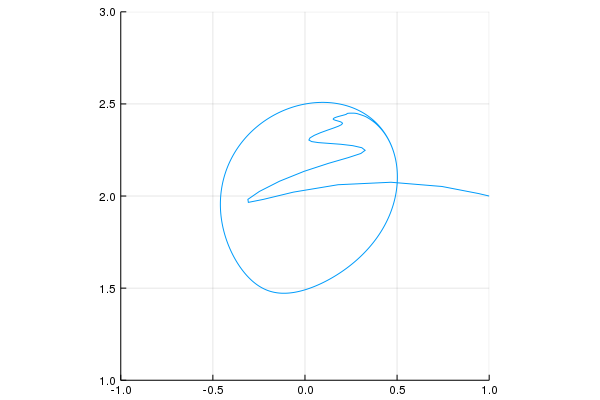

In [16]:
using Plots; gr()

xs = Float64[]
zs = Float64[]

# Downsample by 100 just so the plot doesn't become a huge file:
for q in qs[1:100:end]
    set_configuration!(state, q)
    p = transform(state, point, root_frame(mechanism))
    push!(xs, p.v[1])
    push!(zs, p.v[3])
end

plot(xs, zs, xlim=(-1, 1), ylim=(1, 3), aspect_ratio=:equal, legend=nothing)

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*